In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import threading
import math

import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
import dobroEnv

/home/wooseoko/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
#hyper parameters
t_max = 1
gamma = 0.95
learning_rate = 0.001
beta = 0.1

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
env = gym.make('DobroHalfCheetah-v0')
env.unwrapped.initialize(is_render=False)
print(env.action_space.sample())

[ 0.65888214 -0.8128141  -0.95716935  0.62324756  0.5711904  -0.85067934]


In [4]:
class policy_net(nn.Module):
    def __init__(self, input_feature , num_actions):
        super(policy_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear = nn.Linear(in_features = 128, out_features = 256)
        self.activation2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 256, out_features = num_actions)
        #self.linear3 = nn.Linear(in_features = 256, out_features = num_actions)
        self.mean_act = nn.Tanh()
        

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear(x))
        mean = self.mean_act(self.linear2(x))
        #variance = self.var_act(self.linear3(x)) + 0.0001
        variance = torch.Tensor([0.25, 0.25, 0.25, 0.25, 0.25, 0.25])
        return mean , variance
    
class value_net(nn.Module):
    def __init__(self, input_feature):
        super(value_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear = nn.Linear(in_features = 128, out_features = 256)
        self.activation2 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 256, out_features = 1)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear(x))
        x = self.linear2(x)
        return x
    
    
    

In [5]:

def get_action(mean , variance, num_actions):
    true_action = []
    for i in range(len(mean)):
        for j in range(10000):
            action = np.random.normal(mean[i].detach(), variance[i].detach(), 1).item()
            if(action >= -1 and action <=1):
                true_action.append(action)
                break
        if( len(true_action) <= i):
            true_actioin.append(mean[i])
    return true_action



In [6]:
#multihtread
num_actions = 6
p_net_shared = policy_net(20,num_actions)
v_net_shared = value_net(20)
np.random.seed(seed)
torch.manual_seed(seed)
_lock = threading.Lock()

reward_plot = [0 for i in range(5000)]

def training(idx):
    t_max = 5
    gamma = 0.99
    learning_rate = 0.001
    beta = 0
    step = 0
    state = []
    


    global p_net_shared
    global v_net_shared
    global reward_plot
    
    for iteration in range(5000):
        
        p_optimizer = optim.Adam(p_net_shared.parameters(), lr=learning_rate/1000)
        v_optimizer = optim.Adam(v_net_shared.parameters(), lr=learning_rate)

        done = False
        env = gym.make('DobroHalfCheetah-v0')
        env.unwrapped.initialize(is_render=False)
        observation = env.reset()
        state = observation
        
        p_net = policy_net(20,num_actions)
        v_net = value_net(20)
    
        p_net.zero_grad()
        v_net.zero_grad()
        
        t_update = 0
        #beta -= 0.0002
        #learning_rate -= 0.0009/2000
        if(beta<=0):
            beta = 0
        reward_stack = []
        prob_stack = []
        value_stack = []
        action_stack = []
        entropy = 0
        reward_sum = 0
        policy_loss_sum=0
        value_loss_sum = 0
        entropy_sum = 0
        
        
        mean_average = np.zeros(num_actions)
        variance_average = np.zeros(num_actions)
        
        
        for t in range(10000):

            step = step+1

            mean, variance= p_net(torch.Tensor(state))
            value = v_net(torch.Tensor(state))            
            
            mean_average += mean.detach().numpy()
            variance_average += variance.detach().numpy()
            
            action = get_action(mean,variance,num_actions)
            
            next_state , reward, done, info = env.step(action)
            #reward /= 16.2736044
            reward_sum += reward
            t_update += 1

            reward_stack.append(reward)
            value_stack.append(value)
            prob_stack.append((mean,variance))
            action_stack.append(action)
            
            for i in range(num_actions):
                entropy += -(torch.log(torch.clamp(2*math.pi*variance[i]*variance[i] , min = 1e-6)) + 1)/2

            if(t_update >= t_max or done):
                if(done):
                    R=0
                else:
                    R = v_net(torch.Tensor(next_state))
                policy_loss = 0
                value_loss = 0
                

                for i in range(t_update):
                    R = R*gamma + reward_stack.pop()
                    value_temp = value_stack.pop()
                    mu , var = prob_stack.pop()
                    action_i = action_stack.pop()
                    advantage = (R-value_temp).detach()
                    for j in range(num_actions):
                        policy_loss += ( (( (action_i[j] - mu[j]) )**2)/2 ) * advantage
                    value_loss += (R-value_temp) * (R-value_temp)

                entropy_sum += entropy / t_max
                entropy = -entropy * beta
                policy_loss = policy_loss + entropy 
                policy_loss = policy_loss / t_max
                value_loss = value_loss /t_max

                _lock.acquire()
                
                policy_loss.backward(retain_graph=True)
                value_loss.backward()
                policy_loss_sum += policy_loss.detach().numpy()
                value_loss_sum += value_loss.detach().numpy()
                
                for p_param , s_p_param in zip(p_net.parameters(), p_net_shared.parameters()):
                    s_p_param._grad = p_param.grad.detach()
                    if((s_p_param != s_p_param).any()):
                        print("explode !!!! ")
                        
                        
                for v_param , s_v_param in zip(v_net.parameters(), v_net_shared.parameters()):
                    s_v_param._grad = v_param.grad.detach()
                    if((s_v_param != s_v_param).any()):
                        print("explode !!!! ")
                
                p_optimizer.step()
                v_optimizer.step()
                p_net_shared.zero_grad()
                v_net_shared.zero_grad()

                _lock.release()
                
                
                
                p_net = policy_net(20,num_actions)
                v_net = value_net(20)    

                p_net.load_state_dict(p_net_shared.state_dict())
                v_net.load_state_dict(v_net_shared.state_dict())
                R=0
                entropy = 0
                t_update = 0
            if(done):
                mean_average /= t + 1
                variance_average /= t+1
                break

            #env.render()
            state = next_state[:]
        reward_plot[iteration] += reward_sum
        env.close()
        if(iteration%10 ==0):
            print(policy_loss_sum)
            print(value_loss_sum)
            print(entropy_sum)
            print("mean_average : {}".format(mean_average))
            print("variance_average : {}".format(variance_average))
            print("training idx {} actor true_reward at iteration {} : {}".format(idx,iteration, reward_sum))
            print(step)
            beta = beta * 0.99
            learning_rate = learning_rate * 0.99
th1 = threading.Thread(target = training , args = (1,))
th2 = threading.Thread(target = training , args = (2,))
th3 = threading.Thread(target = training , args = (3,))
th4 = threading.Thread(target = training , args = (4,))

th1.start()
th2.start()
th3.start()
th4.start()

th1.join()
th2.join()
th3.join()
th4.join()

print("finish")

[5.60521]
[366.92993]
tensor(-39.1731)
mean_average : [-0.00536839  0.05315022  0.08189185 -0.27888417  0.0899412   0.0478393 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 0 : 56.19736922552538
1000
[5.0120153]
[435.14655]
tensor(-39.1731)
mean_average : [ 0.0010323   0.05860726  0.09566227 -0.29148956  0.08792027  0.05558522]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 0 : 50.4570366217023
1000
[6.5406537]
[371.34937]
tensor(-39.1731)
mean_average : [ 0.01192016  0.05608866  0.09696835 -0.30071121  0.08454063  0.0572055 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 0 : 69.97200521992515
1000
[4.527835]
[403.79922]
tensor(-39.1731)
mean_average : [ 0.00156254  0.05066252  0.07765667 -0.28440729  0.09522696  0.04560935]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 0 : 48.36166604

[-4.1644883][-1.0711486]
[419.31097]

[691.8176]
tensor(-39.1731)
mean_average : [ 0.29498131 -0.32130297  0.22653419 -0.06286371 -0.29923692  0.09248759]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 80 : 301.77843145760585
81000
tensor(-39.1731)
mean_average : [ 0.28866149 -0.30928236  0.21801838 -0.05086088 -0.2944559   0.07002851]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 80 : 292.3353108178085
81000
[1.6685159]
[502.9514]
tensor(-39.1731)
mean_average : [ 0.32233839 -0.34347812  0.23466061 -0.06785643 -0.31370325  0.08625637]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 90 : 274.98471406042415
91000
[-3.6597123]
[459.2766]
tensor(-39.1731)
mean_average : [ 0.34001013 -0.34735282  0.23162769 -0.07361049 -0.32416037  0.09698816]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 90 

[2.3571837]
[601.36304]
tensor(-39.1731)
mean_average : [ 0.42232617 -0.45836285  0.26555984  0.0624125  -0.28050334  0.1095586 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 160 : 363.7581708544995
161000
[-9.550883]
[700.31165]
tensor(-39.1731)
mean_average : [ 0.43252131 -0.46994101  0.27562608  0.06081536 -0.2918462   0.11048928]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 160 : 257.9693444034381
161000
[1.6917362]
[563.4794]
tensor(-39.1731)
mean_average : [ 0.46471363 -0.49157788  0.29931663  0.08524638 -0.29097325  0.13167315]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 170 : 346.82439914863994
171000
[-4.0424166]
[880.18207]
tensor(-39.1731)
mean_average : [ 0.45840693 -0.47955637  0.29020618  0.0687861  -0.29760454  0.12513895]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteratio

[-0.98982537]
[530.8358]
tensor(-39.1731)
mean_average : [ 0.54787341 -0.50470355  0.35351654  0.17010763 -0.2483568   0.16634875]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 240 : 265.04741395030516
241000
[-5.2128515]
[491.9675]
tensor(-39.1731)
mean_average : [ 0.54599395 -0.50357929  0.34961886  0.17316624 -0.24223048  0.15805925]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 240 : 243.4605681951125
241000
[0.94364023]
[352.11493]
tensor(-39.1731)
mean_average : [ 0.55323719 -0.49961915  0.3616113   0.17545072 -0.23397766  0.15060716]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 250 : 323.7618281521408
251000
[-6.2666254]
[460.48203]
tensor(-39.1731)
mean_average : [ 0.56148984 -0.51018809  0.36607226  0.17097042 -0.24157403  0.15288871]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at itera

[0.69798255]
[307.57407]
tensor(-39.1731)
mean_average : [ 0.61680032 -0.52948186  0.45146007  0.23917661 -0.26592682  0.15433441]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 320 : 278.8794469173329
321000
[-4.9643497]
[368.10278]
tensor(-39.1731)
mean_average : [ 0.6140726  -0.52440804  0.45070578  0.22881841 -0.2730792   0.15276206]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 320 : 234.9147096609846
321000
[-6.4170775]
[409.96344]
tensor(-39.1731)
mean_average : [ 0.62814079 -0.53224116  0.46478125  0.23464005 -0.2816499   0.15116414]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 330 : 236.65815480610394
331000
[-0.27815127]
[303.82602]
tensor(-39.1731)
mean_average : [ 0.60106055 -0.50565258  0.43920443  0.23111312 -0.26665535  0.13060503]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at ite

[-2.107349]
[894.3026]
tensor(-39.1731)
mean_average : [ 0.64745197 -0.5001162   0.56163195  0.24877464 -0.34048942  0.15628467]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 400 : 342.3931968890883
401000
[-7.6467566]
[1285.1415]
tensor(-39.1731)
mean_average : [ 0.64030908 -0.48971618  0.57739323  0.23468864 -0.34654507  0.15536141]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 410 : 356.97342961855634
411000
[-4.926402]
[1242.0714]
tensor(-39.1731)
mean_average : [ 0.64801237 -0.49457321  0.58238076  0.22931793 -0.35438764  0.1665841 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 410 : 356.1003378494931
411000
[-6.8571014]
[878.63586]
tensor(-39.1731)
mean_average : [ 0.64093866 -0.49181033  0.57521801  0.23331433 -0.34978796  0.15991386]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iterati

[-8.001684]
[2566.2595]
tensor(-39.1731)
mean_average : [ 0.6223054  -0.4495042   0.67987107  0.21760944 -0.41163668  0.2063632 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 480 : 543.6468811031582
481000
[-10.317665]
[2523.8745]
tensor(-39.1731)
mean_average : [ 0.61393131 -0.43535586  0.67591997  0.2216663  -0.41937557  0.19685077]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 490 : 499.75125028636785
491000
[0.7072458]
[2221.3425]
tensor(-39.1731)
mean_average : [ 0.62236744 -0.44540911  0.69066918  0.23695955 -0.42430973  0.20319837]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 490 : 619.2555455523511
491000
[-13.680241]
[2171.425]
tensor(-39.1731)
mean_average : [ 0.60771743 -0.43121728  0.66110445  0.22886915 -0.41668056  0.18393745]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iterati

[-8.086922]
[4497.055]
tensor(-39.1731)
mean_average : [ 0.54862656 -0.35519643  0.6832687   0.21638035 -0.48644098  0.19191751]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 560 : 615.8683265684243
561000
[-5.9053793]
[3061.3286]
tensor(-39.1731)
mean_average : [ 0.51642848 -0.32865015  0.68529038  0.22192992 -0.47237792  0.22328055]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 570 : 677.3406356965514
571000
[-7.1133184]
[2784.4363]
tensor(-39.1731)
mean_average : [ 0.51095676 -0.32851536  0.67285432  0.23356863 -0.46885479  0.19925974]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 570 : 667.8165813276762
571000
[-1.2665954]
[2163.6843]
tensor(-39.1731)
mean_average : [ 0.52841162 -0.3346613   0.69807299  0.2249017  -0.48819952  0.2281486 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iterati

[6.807461]
[4665.3633]
tensor(-39.1731)
mean_average : [ 0.40438909 -0.30325901  0.70626009  0.24020069 -0.44243184  0.26220234]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 640 : 892.9474781408152
641000
[-9.398168]
[3651.619]
tensor(-39.1731)
mean_average : [ 0.39420915 -0.29102968  0.65954848  0.22336491 -0.42885195  0.21575819]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 650 : 705.4235878785514
651000
[-18.008152]
[3704.3213]
tensor(-39.1731)
mean_average : [ 0.39633859 -0.29854067  0.6583804   0.2188137  -0.41698319  0.22367702]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 650 : 626.2082999436303
651000
[-7.0917153]
[2891.646]
tensor(-39.1731)
mean_average : [ 0.39907683 -0.29039206  0.69018137  0.22203959 -0.42255461  0.24491946]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 

[-12.661844]
[6662.9272]
tensor(-39.1731)
mean_average : [ 0.39131181 -0.27497577  0.67969802  0.23971704 -0.36703662  0.28289108]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 720 : 774.7133189877086
721000
[-18.409348]
[7265.1133]
tensor(-39.1731)
mean_average : [ 0.37689961 -0.25785915  0.66665265  0.22065613 -0.34782566  0.27902133]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 730 : 695.3855436825643
731000
[-12.983357]
[7867.17]
tensor(-39.1731)
mean_average : [ 0.37675862 -0.25855498  0.68511923  0.22472151 -0.35147843  0.29293022]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 730 : 827.3694362945457
731000
[-1.4414997]
[6274.752]
tensor(-39.1731)
mean_average : [ 0.37956215 -0.26010454  0.70446396  0.23902674 -0.35572692  0.30956262]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteratio

[-17.728573]
[7663.9434]
tensor(-39.1731)
mean_average : [ 0.33024441 -0.23134315  0.69398901  0.2065834  -0.33238479  0.31751515]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 800 : 741.1953701063276
801000
[-25.923695]
[6029.872]
tensor(-39.1731)
mean_average : [ 0.33094567 -0.24554027  0.65715601  0.22549718 -0.30713765  0.28463678]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 810 : 694.2771831483565
811000
[-1.716721]
[4378.4287]
tensor(-39.1731)
mean_average : [ 0.32575192 -0.2367828   0.66965403  0.23232558 -0.30575553  0.28859193]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 810 : 855.8748845756058
811000
[-15.974846]
[6689.1333]
tensor(-39.1731)
mean_average : [ 0.3336394  -0.24117645  0.66972985  0.22747057 -0.31887078  0.28602826]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iterati

[-24.847425]
[7674.4834]
tensor(-39.1731)
mean_average : [ 0.29688435 -0.23850265  0.66091938  0.24890334 -0.25053269  0.32401916]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 880 : 600.646877677323
881000
[-15.568248]
[4374.163]
tensor(-39.1731)
mean_average : [ 0.3142057  -0.24233458  0.68107002  0.2863803  -0.23914638  0.33736327]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 890 : 813.2409033703884
891000
[-13.483866]
[3160.3074]
tensor(-39.1731)
mean_average : [ 0.30947728 -0.24404789  0.68029151  0.28528436 -0.2464824   0.34641466]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 890 : 776.5719825358303
891000
[-14.751941]
[3150.8923]
tensor(-39.1731)
mean_average : [ 0.31890301 -0.23630361  0.67109821  0.27928504 -0.2422694   0.33623964]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iterati

[-5.026659]
[3776.0134]
tensor(-39.1731)
mean_average : [ 0.32429601 -0.2450157   0.66753806  0.29814856 -0.17624763  0.32049353]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 960 : 846.2397080709491
961000
[-10.87229]
[6063.9883]
tensor(-39.1731)
mean_average : [ 0.31456139 -0.22791547  0.67119062  0.28692001 -0.18812746  0.32212472]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 970 : 776.8764926116105
971000
[-3.9567852]
[6521.2476]
tensor(-39.1731)
mean_average : [ 0.32032085 -0.23070785  0.67862446  0.3014843  -0.17091514  0.32828237]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 970 : 888.7610964934157
971000
[-6.1222763]
[4516.026]
tensor(-39.1731)
mean_average : [ 0.33096615 -0.24428457  0.66749976  0.29120804 -0.17876399  0.30283059]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteratio

[-9.483972]
[3578.4795]
tensor(-39.1731)
mean_average : [ 0.33028687 -0.22673658  0.6746314   0.31261649 -0.10068023  0.34081799]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1040 : 842.7844970627473
1041000
[-12.518311]
[8265.067]
tensor(-39.1731)
mean_average : [ 0.33553219 -0.2164467   0.67033969  0.30376296 -0.10902564  0.32273467]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1050 : 771.7520324168283
1051000
[-7.0954456]
[5844.0845]
tensor(-39.1731)
mean_average : [ 0.3436911  -0.2300489   0.67515911  0.31378164 -0.09666733  0.33536926]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1050 : 870.0246189599594
1051000
[-22.334475]
[6187.906]
tensor(-39.1731)
mean_average : [ 0.34072902 -0.22798952  0.66737858  0.3038884  -0.10481315  0.32075312]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at it

[5.018897]
[1788.0371]
tensor(-39.1731)
mean_average : [ 0.34878676 -0.22799168  0.66557522  0.31475852 -0.04842286  0.31095627]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1120 : 826.5851338617067
1121000
[-0.49510288]
[1383.3868]
tensor(-39.1731)
mean_average : [ 0.34528014 -0.21915175  0.6576375   0.31093758 -0.05575808  0.29653624]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1130 : 788.8684101581484
1131000
[-14.972229]
[2197.1865]
tensor(-39.1731)
mean_average : [ 0.34341082 -0.20512516  0.6471273   0.2894603  -0.06876611  0.28135064]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1130 : 661.6537029350484
1131000
[-4.826847]
[1843.679]
tensor(-39.1731)
mean_average : [ 0.34927751 -0.22054628  0.6650265   0.31760168 -0.0620992   0.30682997]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at it

[-16.95741]
[5290.281]
tensor(-39.1731)
mean_average : [ 0.3617039  -0.20562167  0.66328188  0.27379536 -0.05213337  0.26183205]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1200 : 668.7407036214696
1201000
[-9.715607]
[4009.062]
tensor(-39.1731)
mean_average : [ 0.37556175 -0.21584457  0.66607926  0.2811981  -0.03623842  0.25578865]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1210 : 813.3386605463256
1211000
[-11.180105]
[6198.7734]
tensor(-39.1731)
mean_average : [ 0.37535362 -0.20813349  0.66594786  0.27539708 -0.03479861  0.244898  ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1210 : 755.4059262192519
1211000
[-3.1219273]
[7297.4487]
tensor(-39.1731)
mean_average : [ 0.37631843 -0.2121814   0.67782426  0.28427072 -0.03649258  0.26112637]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at ite

[-4.611701]
[5625.026]
tensor(-39.1731)
mean_average : [ 0.36590827 -0.19039472  0.67156368  0.26838301 -0.02746344  0.27207337]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1280 : 801.510237217245
1281000
[-6.287322]
[4508.9756]
tensor(-39.1731)
mean_average : [ 0.3652417  -0.19562482  0.67305557  0.28028259 -0.01415897  0.26920604]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1290 : 940.7978879226713
1291000
[-15.184275]
[3816.423]
tensor(-39.1731)
mean_average : [ 0.37482279 -0.20495055  0.67497843  0.28239927 -0.01661121  0.25558772]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1290 : 799.1419593210503
1291000
[1.3838778]
[3306.1833]
tensor(-39.1731)
mean_average : [ 0.37133989 -0.1972484   0.6723335   0.28666295 -0.01091744  0.26308639]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at itera

[-3.187634]
[779.16895]
tensor(-39.1731)
mean_average : [ 0.3713221  -0.20280445  0.66334701  0.28683078  0.01422092  0.25002268]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1360 : 789.038067800318
1361000
[-16.14071]
[3705.7903]
tensor(-39.1731)
mean_average : [ 0.36832583 -0.20897149  0.65781816  0.28377309  0.01072646  0.24369174]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1370 : 700.8346771333798
1371000
[-1.6268792]
[1311.8542]
tensor(-39.1731)
mean_average : [ 0.38218377 -0.21428114  0.66335433  0.29632632  0.02097834  0.24338477]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1370 : 791.1575109630114
1371000
[-19.782522]
[1893.0099]
tensor(-39.1731)
mean_average : [ 0.37906433 -0.20852039  0.65563107  0.28252113  0.01304084  0.23823533]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at it

[-8.189275]
[3537.335]
tensor(-39.1731)
mean_average : [ 0.3877158  -0.21326522  0.67782236  0.27914256  0.03359035  0.24410152]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1440 : 750.1754391780576
1441000
[-4.3784695]
[1743.6914]
tensor(-39.1731)
mean_average : [ 0.3885732  -0.23565676  0.66256272  0.29454624  0.02055262  0.22082236]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1450 : 713.056701025584
1451000
[-15.987735]
[1378.614]
tensor(-39.1731)
mean_average : [ 0.37883088 -0.21747457  0.6617594   0.27197597  0.02853804  0.2274156 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1450 : 594.7291585110064
1451000
[0.41944742]
[1276.0449]
tensor(-39.1731)
mean_average : [ 0.38545901 -0.2217032   0.67412044  0.28444325  0.02782734  0.23571487]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at ite

[-4.5057716]
[4406.1313]
tensor(-39.1731)
mean_average : [ 0.38708029 -0.1991573   0.68246171  0.30040948  0.04114428  0.25363753]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 1520 : 830.7105186470294
1521000
[2.7105818]
[3306.5725]
tensor(-39.1731)
mean_average : [ 0.38728635 -0.19527328  0.67715688  0.29928788  0.03991314  0.2585428 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1530 : 789.2007785646871
1531000
[-8.445955]
[5853.8594]
tensor(-39.1731)
mean_average : [ 0.38808458 -0.20064676  0.66304183  0.2957546   0.03471369  0.24605763]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1530 : 701.2658241761952
1531000
[-1.2515535]
[2690.1304]
tensor(-39.1731)
mean_average : [ 0.38974952 -0.20130663  0.67364363  0.30066952  0.03919184  0.24448219]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at i

[-4.7322326]
[1875.0508]
tensor(-39.1731)
mean_average : [ 0.39960713 -0.18539657  0.67114285  0.31707137  0.05132621  0.23485286]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1610 : 828.8567312081938
1611000
[-18.405205]
[2521.3623]
tensor(-39.1731)
mean_average : [ 0.40599639 -0.19576197  0.66802932  0.3160465   0.04231834  0.21963663]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1610 : 733.9216140201704
1611000
[-10.188034]
[2110.2744]
tensor(-39.1731)
mean_average : [ 0.39375126 -0.18068394  0.67694242  0.32053193  0.05069581  0.23994799]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1610 : 796.1940943019875
1611000
[11.527647]
[1105.5177]
tensor(-39.1731)
mean_average : [ 0.40160143 -0.18199827  0.69620049  0.33141573  0.06110852  0.25561203]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at 

[-7.424969]
[3344.1348]
tensor(-39.1731)
mean_average : [ 0.41132767 -0.18787109  0.68039011  0.34150282  0.0500725   0.24087001]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1690 : 756.3095715808731
1691000
[-1.0441203]
[1856.9407]
tensor(-39.1731)
mean_average : [ 0.39958065 -0.18173264  0.67649094  0.33558578  0.06820313  0.23866348]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1690 : 786.8842269867569
1691000
[-13.0144415]
[3006.6738]
tensor(-39.1731)
mean_average : [ 0.40365547 -0.17525565  0.67795519  0.3218707   0.04673353  0.24378576]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1690 : 761.1701331432209
1691000
[-5.248006]
[2042.9789]
tensor(-39.1731)
mean_average : [ 0.40619262 -0.19221246  0.67252976  0.32759763  0.05499077  0.24038136]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at 

[-16.157307]
[4297.8696]
tensor(-39.1731)
mean_average : [ 0.4007902  -0.17864738  0.6938182   0.37550348  0.06859593  0.26133608]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1770 : 756.9995322860494
1771000
[5.3301463]
[1582.1307]
tensor(-39.1731)
mean_average : [ 0.40887794 -0.17639781  0.69404735  0.37746508  0.07508965  0.25957043]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1770 : 914.6655343756695
1771000
[-6.34264]
[2468.5884]
tensor(-39.1731)
mean_average : [ 0.40394542 -0.17871442  0.68852632  0.36031445  0.06089827  0.24814708]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1770 : 812.1148037889066
1771000
[-17.472008]
[3609.0852]
tensor(-39.1731)
mean_average : [ 0.41830971 -0.18500316  0.68626777  0.36215418  0.05433857  0.25069865]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at it

[-6.4273357]
[4959.5347]
tensor(-39.1731)
mean_average : [ 0.40559988 -0.18082698  0.66805143  0.37615176  0.05850706  0.23631976]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1850 : 747.318526274889
1851000
[-8.994814]
[4080.731]
tensor(-39.1731)
mean_average : [ 0.40931611 -0.18224698  0.67304374  0.3798988   0.06400032  0.23469365]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1850 : 792.0328194133942
1851000
[-9.248274]
[5101.2183]
tensor(-39.1731)
mean_average : [ 0.41313609 -0.18027245  0.67342968  0.37394961  0.05832984  0.23254881]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1850 : 723.8739592767532
1851000
[-10.097621]
[3454.9492]
tensor(-39.1731)
mean_average : [ 0.41345202 -0.18675284  0.67719676  0.3705936   0.05068615  0.24099981]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at ite

[-27.52935]
[4244.9463]
tensor(-39.1731)
mean_average : [ 0.40867447 -0.18100076  0.66347559  0.37364129  0.03767408  0.21666007]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 1930 : 583.8992045097887
1931000
[-14.684152]
[4223.3267]
tensor(-39.1731)
mean_average : [ 0.40817661 -0.17398785  0.66936863  0.38118437  0.04892374  0.22408381]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 1930 : 681.349638171294
1931000
[4.442377]
[3939.3345]
tensor(-39.1731)
mean_average : [ 0.40403778 -0.16516272  0.67397144  0.39603005  0.04943396  0.24128809]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 1930 : 845.3821727332734
1931000
[3.6000223]
[3901.9355]
tensor(-39.1731)
mean_average : [ 0.4032908  -0.16667569  0.68430922  0.40041178  0.05381305  0.23945861]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iter

[-35.57728]
[5747.5083]
tensor(-39.1731)
mean_average : [ 0.41387778 -0.16934159  0.66874524  0.39423593  0.02981614  0.21047725]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 2010 : 581.804504888342
2011000
[-10.178117]
[3617.1533]
tensor(-39.1731)
mean_average : [ 0.40979639 -0.17102811  0.68006745  0.40349405  0.05143739  0.22389827]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 2010 : 734.2497806334252
2011000
[-1.7859664]
[2298.5183]
tensor(-39.1731)
mean_average : [ 0.4174527  -0.17086221  0.69500144  0.41837966  0.04965607  0.23202447]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 2010 : 836.371143252291
2011000
[3.0627341]
[1718.863]
tensor(-39.1731)
mean_average : [ 0.41991265 -0.17623223  0.68898559  0.41874071  0.05737449  0.22456528]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iter

[-5.0213323]
[4525.005]
tensor(-39.1731)
mean_average : [ 0.40757618 -0.17051057  0.68275405  0.43168929  0.05936111  0.23693744]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 2090 : 781.8034059804046
2091000
[-6.505791]
[4717.8716]
tensor(-39.1731)
mean_average : [ 0.40382018 -0.16383578  0.68045348  0.42933186  0.05073693  0.22906958]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 2090 : 774.1082149229231
2091000
[-4.7872014]
[5449.1753]
tensor(-39.1731)
mean_average : [ 0.40901331 -0.16762924  0.68929763  0.43250218  0.04075119  0.23354488]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 2090 : 791.1671731469465
2091000
[-11.525642]
[4616.71]
tensor(-39.1731)
mean_average : [ 0.4182639  -0.18109549  0.68990558  0.43544903  0.03545973  0.22459062]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at ite

[3.346262]
[1562.7507]
tensor(-39.1731)
mean_average : [ 0.42095922 -0.16617116  0.69662586  0.4515508   0.04122417  0.2257593 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 2170 : 784.4052144774992
2171000
[-0.7982235]
[1985.3142]
tensor(-39.1731)
mean_average : [ 0.40662616 -0.16260153  0.67011304  0.43350128  0.03906884  0.21430939]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 2170 : 752.9648146165205
2171000
[-19.17224]
[3553.5974]
tensor(-39.1731)
mean_average : [ 0.4215458  -0.17748288  0.68366611  0.43961003  0.03324653  0.21663071]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 2170 : 599.0193525445197
2171000
[-9.758286]
[2103.7275]
tensor(-39.1731)
mean_average : [ 0.40619935 -0.1725076   0.68263287  0.43908183  0.04026648  0.22165338]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at ite

[-6.7930875]
[5205.5166]
tensor(-39.1731)
mean_average : [ 0.41354463 -0.17244049  0.68884481  0.45472056  0.02927151  0.23506734]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 2250 : 745.4152940648672
2251000
[0.6249261]
[3314.7375]
tensor(-39.1731)
mean_average : [ 0.41981338 -0.17128873  0.69783894  0.46553762  0.04655236  0.23191077]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 2250 : 817.4253445378097
2251000
[-20.433002]
[3423.8606]
tensor(-39.1731)
mean_average : [ 0.41811508 -0.17270236  0.68594287  0.45234706  0.03186268  0.22942127]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 2250 : 691.6038675580685
2251000
[-15.006235]
[4150.513]
tensor(-39.1731)
mean_average : [ 0.42383521 -0.18057658  0.69074778  0.45445535  0.03961741  0.23066095]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at i

[-31.706455]
[3895.6545]
tensor(-39.1731)
mean_average : [ 0.42427407 -0.18356842  0.69644797  0.45659255  0.023697    0.22783069]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 2330 : 500.2045997129585
2331000
[9.170728]
[2267.1738]
tensor(-39.1731)
mean_average : [ 0.41772054 -0.169908    0.69947737  0.47147468  0.05266257  0.23818586]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 2330 : 775.0306529229878
2331000
[-23.478722]
[4305.4854]
tensor(-39.1731)
mean_average : [ 0.4168325  -0.18814336  0.6697808   0.44107528  0.03232775  0.20770889]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 2330 : 531.8453364135886
2331000
[-4.480445]
[2128.4404]
tensor(-39.1731)
mean_average : [ 0.42225969 -0.18816892  0.67739967  0.45927277  0.04095982  0.20670323]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at it

[-14.844516]
[4727.7993]
tensor(-39.1731)
mean_average : [ 0.41462995 -0.17502775  0.68365865  0.46913992  0.04731015  0.22227107]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 2410 : 696.3553857792378
2411000
[-2.52244]
[2962.1628]
tensor(-39.1731)
mean_average : [ 0.42624367 -0.18169262  0.69648013  0.48022966  0.05423084  0.23136881]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 2410 : 791.6917062980308
2411000
[-3.3445065]
[3268.9385]
tensor(-39.1731)
mean_average : [ 0.42668274 -0.18112919  0.69522664  0.48210605  0.04766277  0.21825804]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 2410 : 718.0973884852606
2411000
[-14.94601]
[4425.623]
tensor(-39.1731)
mean_average : [ 0.41719025 -0.18788946  0.68602334  0.47257605  0.04099939  0.22496245]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at ite

KeyboardInterrupt: 

Text(0.5, 1.0, 'reward')

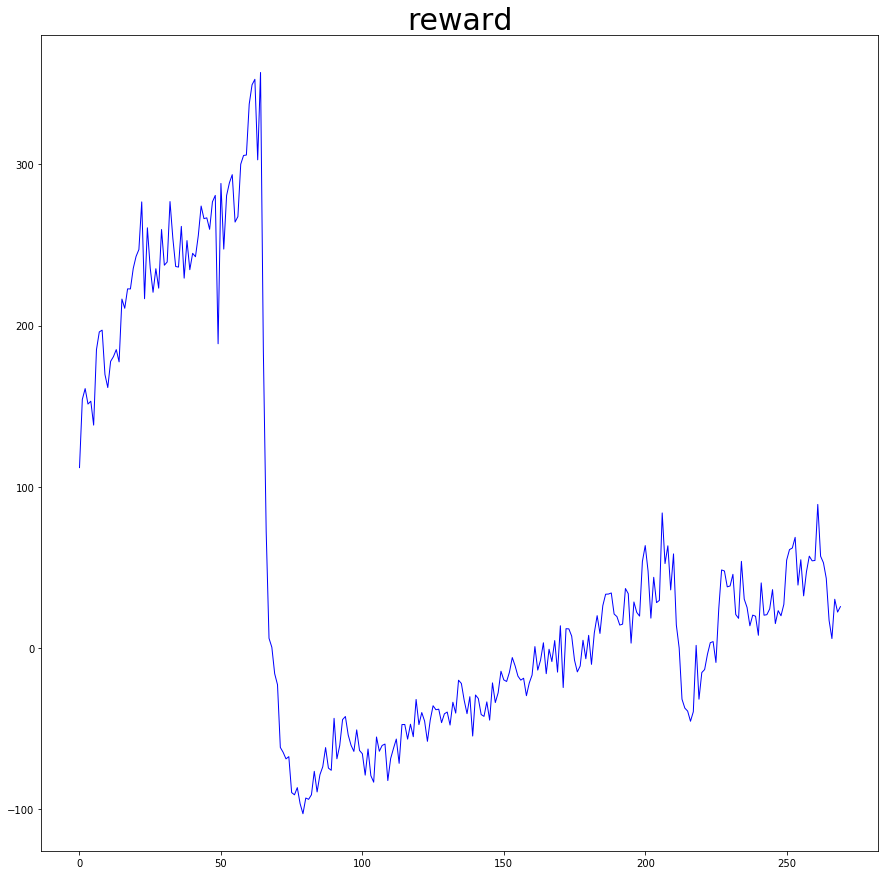

[1.5081582]
[89.75523]
tensor(-39.1731)
mean_average : [-0.50640523 -0.62242595  0.9679677   0.90467709  0.38059821  0.80147466]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 4 actor true_reward at iteration 280 : 37.6251369320111
281000
[-0.54233056]
[86.40703]
tensor(-39.1731)
mean_average : [-0.49266385 -0.60641742  0.96801707  0.90131261  0.38492766  0.79737826]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 3 actor true_reward at iteration 280 : 23.097752221510355
281000
[-1.499681]
[61.598125]
tensor(-39.1731)
mean_average : [-0.48326331 -0.60888806  0.96815962  0.90383189  0.35293652  0.78592281]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 2 actor true_reward at iteration 280 : 30.270807031074998
281000
[-3.0493608]
[63.070644]
tensor(-39.1731)
mean_average : [-0.50536101 -0.61235621  0.96793374  0.90509004  0.38825313  0.80278091]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iterati

In [8]:
reward_np = np.array(reward_plot[:270])  /4
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


In [8]:
#test
state = []
done = False
reward_sum=0
env = gym.make('DobroHalfCheetah-v0')
env.unwrapped.initialize(is_render=True)

observation = env.reset()

state = observation

for t in range(10000):
    env.render()
    
    mean, variance= p_net_shared(torch.Tensor(state))
    value = v_net_shared(torch.Tensor(state))

    action = get_action(mean,variance,num_actions)
    
    obs , reward, done, info = env.step(action)
    
    
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

KeyboardInterrupt: 

Text(0.5, 1.0, 'reward')

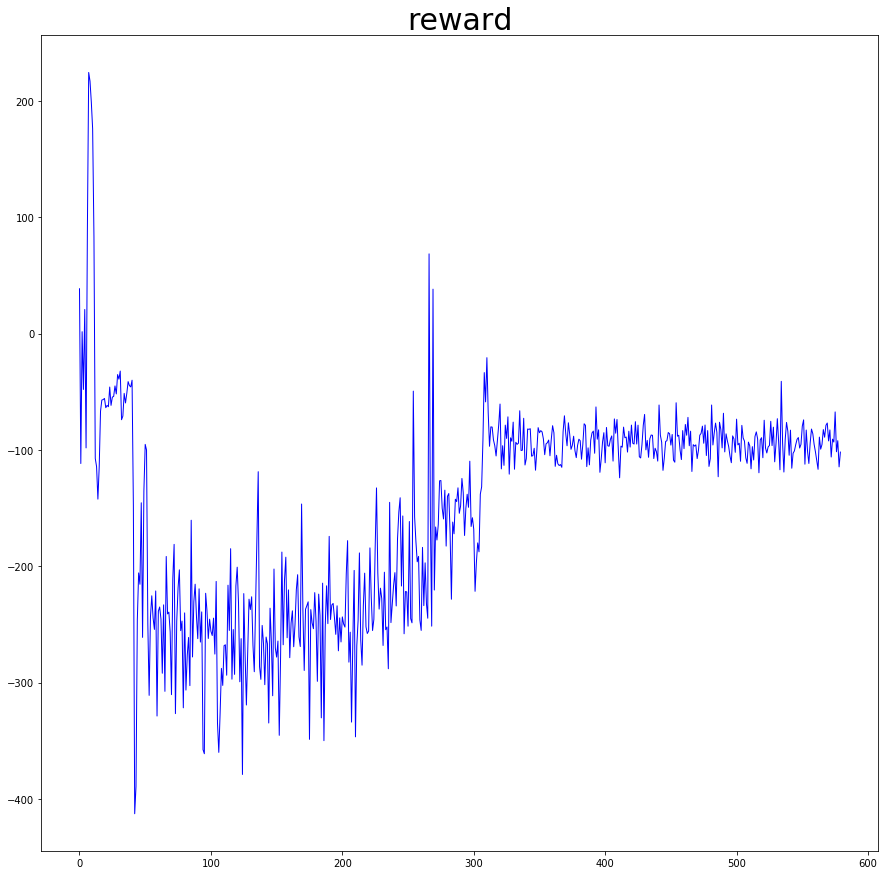

In [7]:
reward_np = np.array(reward_plot[:580])  
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


Text(0.5, 1.0, 'reward')

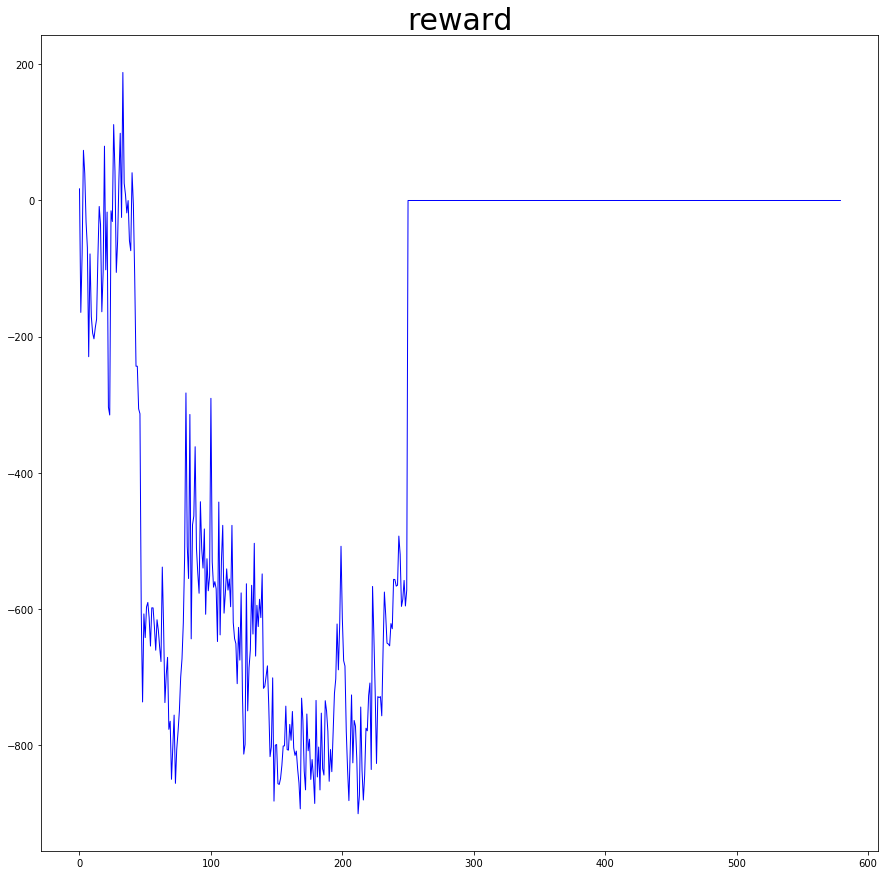

[-45.180073]
[606.3712]
tensor(-39.1731)
mean_average : [ 0.02810027 -0.1132439  -0.05810465  0.99444394 -0.99540649  0.0590282 ]
variance_average : [0.25 0.25 0.25 0.25 0.25 0.25]
training idx 1 actor true_reward at iteration 250 : -517.8124400116419
251000


In [7]:
reward_np = np.array(reward_plot[:580])  
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


Text(0.5, 1.0, 'reward')

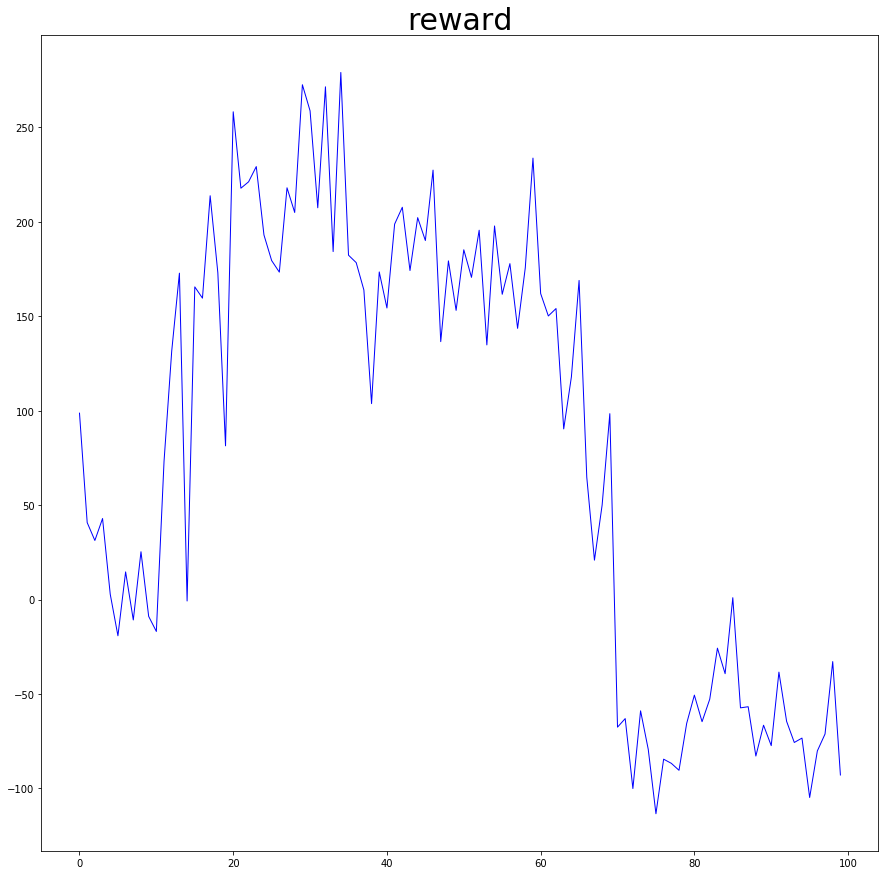

In [7]:
reward_np = np.array(reward_plot[:100])  
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)
